In [7]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


In [13]:
TRAIN_DIR = '/home/sneha/Catdata/train/'
TEST_DIR = '/home/sneha/Catdata/test/'
ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


In [14]:
# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]

In [15]:

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25
Train shape: (2000, 3, 64, 64)
Test shape: (25, 3, 64, 64)


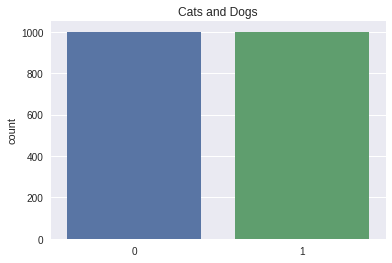

In [16]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
sns.plt.title('Cats and Dogs')

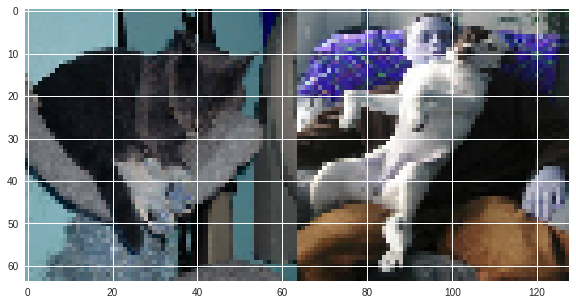

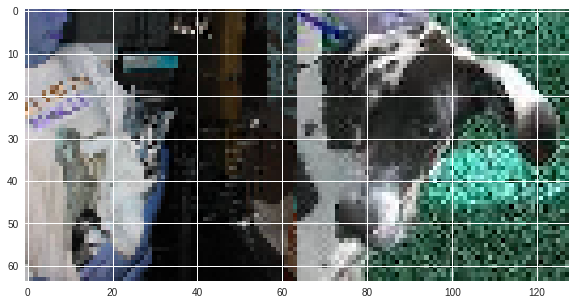

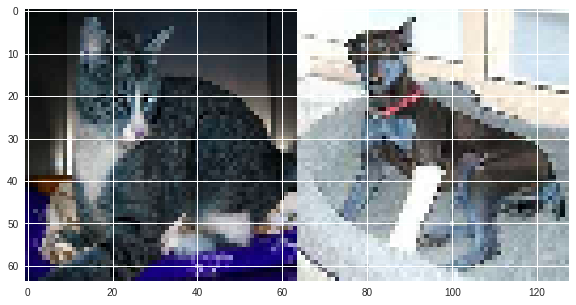

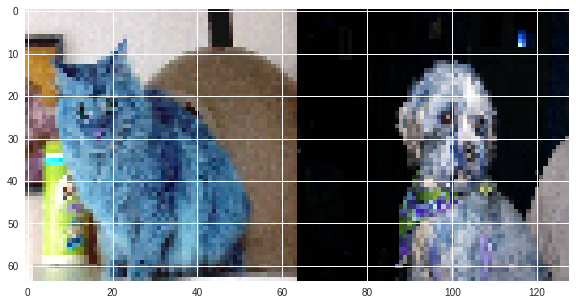

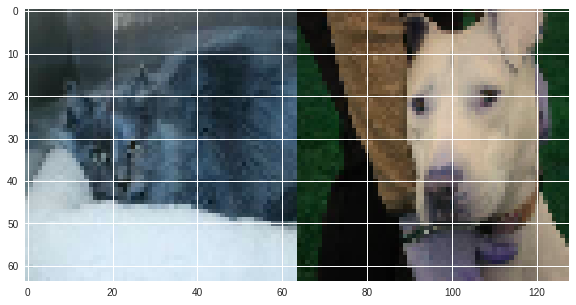

In [17]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

In [26]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()


In [31]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

print("hi")
    

hi


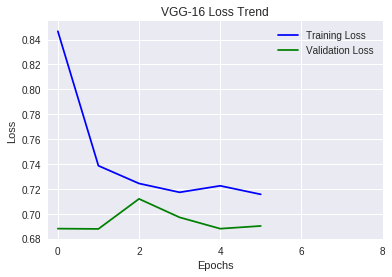

In [28]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

I am 62.35% sure this is a Cat


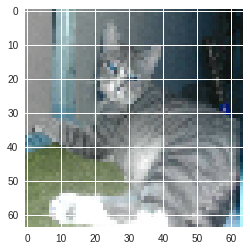

hi
I am 53.66% sure this is a Dog


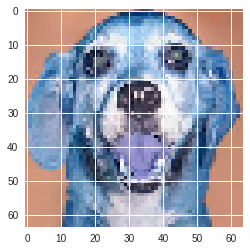

hi
I am 56.45% sure this is a Cat


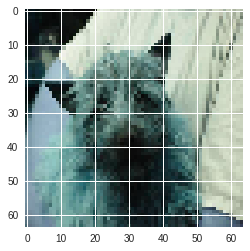

hi
I am 56.10% sure this is a Cat


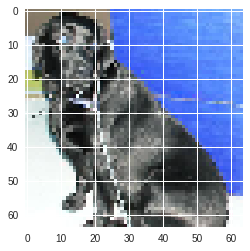

hi
I am 67.12% sure this is a Cat


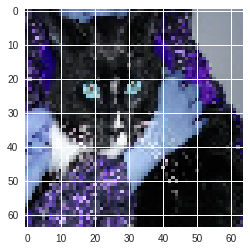

hi
I am 52.47% sure this is a Cat


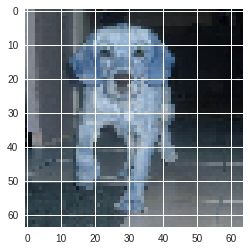

hi
I am 53.60% sure this is a Cat


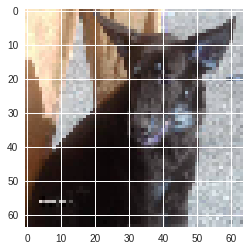

hi
I am 51.39% sure this is a Cat


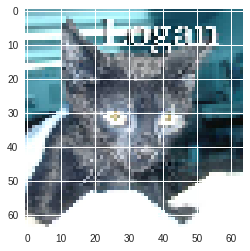

hi
I am 51.19% sure this is a Dog


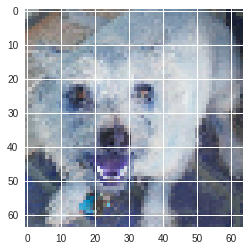

hi
I am 53.79% sure this is a Cat


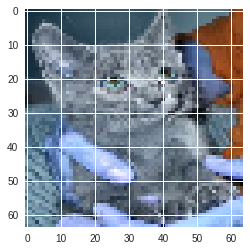

hi


In [36]:
for i in range(0,10):
   
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()
    print("hi")